# A simple nb to learn about backpropagation on neural nets

### Starting with a simple view of derivatives

In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def f(x):
    return 3*x**2 - 4*x +5

In [14]:
f(3.0)

20.0

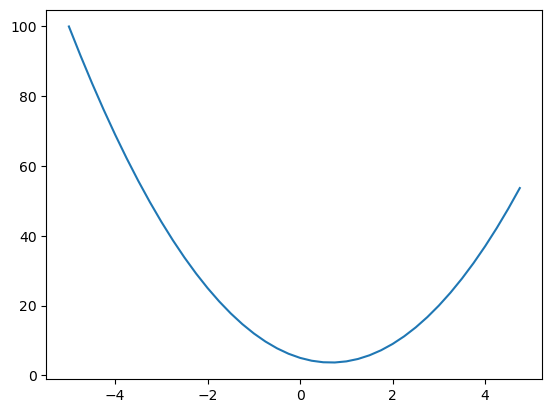

In [15]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [16]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x))/h

2.9753977059954195e-07

In [17]:
# a bit more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [18]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)

# get slope
print('slope', (d2-d1)/h)

# changing b
a -= h
b += h
d2 = a*b +c

# get slope
print('slope 2', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772
slope 2 2.0000000000042206


### Start with classes representing a scalar

In [79]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(2.0, label='f')
L = d + f; L.label = 'L'

d

Value(data=4.0)


### Adding visualization

For extra info check: https://graphviz.readthedocs.io/en/stable/manual.html

In [39]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

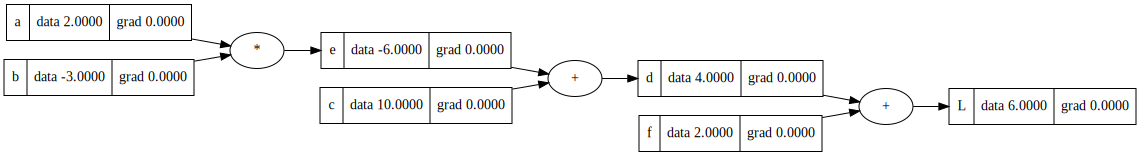

In [40]:
draw_dot(L)

### Graphical visualization of tanh

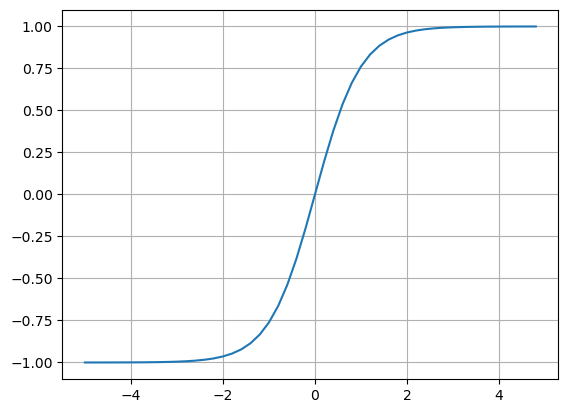

In [42]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

### Crating a neuron

In [80]:
# inputs x1, x2
# weights w1, w2
# bias b

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735, label='b')

# compute sinapses

x1w1 = x1*w1; x1w1.label= 'x1*w1'
x2w2 = x2*w2; x2w2.label= 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 +b; n.label = 'n' # cell body without activation

o = n.tanh(); o.label = 'o'







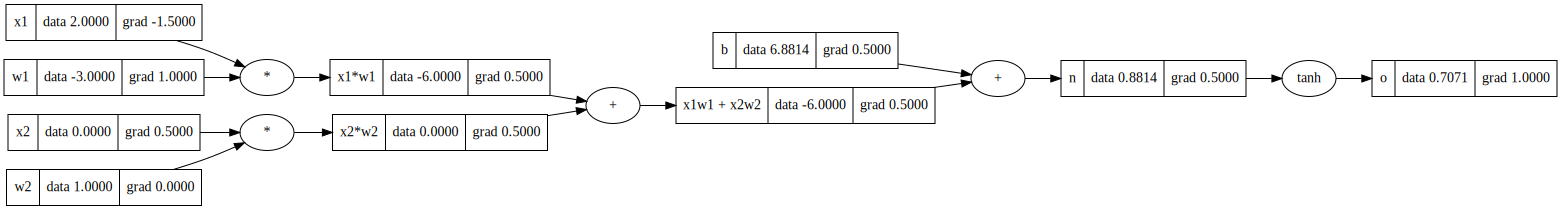

In [83]:
draw_dot(o)

In [82]:
o.backward()

In [75]:
o.grad = 1.0

In [76]:
o._backward()

In [77]:
n._backward()